In [201]:
from PIL import Image;
import numpy as np;
import matplotlib.pyplot as plt
from math import *

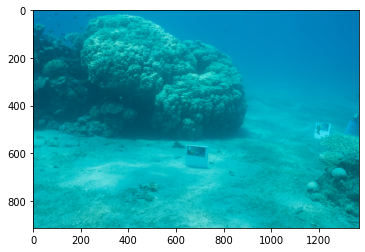

In [202]:
image = Image.open("../resources/image3_low.png")
plt.imshow(image)


In [203]:
width, height = image.size
imageArr = np.asarray(image)
imageArr.shape

(914, 1369, 3)

In [204]:
def plot_data(img, fig):
    ax = fig.add_subplot(projection='3d')
    ax.scatter(img[...,0].ravel(), 
                img[...,1].ravel(), 
                img[...,2].ravel(),
                c=img.reshape((-1,3))/255, 
                marker='.', 
                alpha=0.2)
    ax.set_xlabel("Red")
    ax.set_xlim3d(0, 255)
    ax.set_ylabel("Green")
    ax.set_ylim3d(0, 255)
    ax.set_zlabel("Blue")
    ax.set_zlim3d(0, 255)
    plt.title("Color distribution of our image")

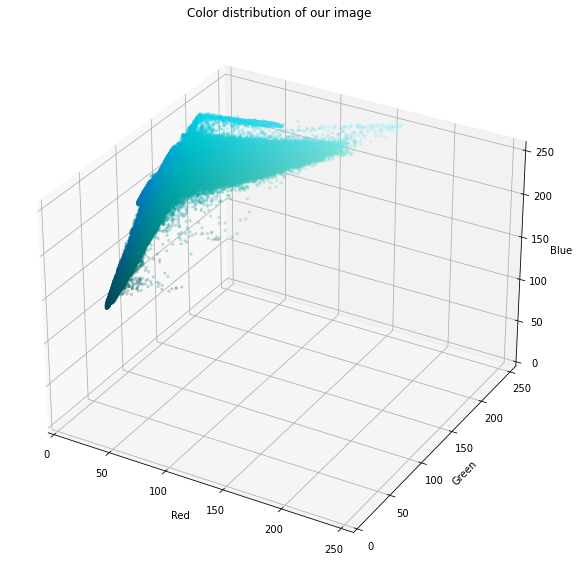

In [205]:
figure = plt.figure(figsize=(10,10))
plot_data(imageArr, figure)

In [206]:
def pickJerlovColors() :  
    image = np.asarray(Image.open("../resources/water_types.png"))[...,:3]
    height, width = image.shape[0], image.shape[1]
    deltaHeight = (int)(height / 6)
    deltaWidth = (int)(width / 20)
    colors = []
    for i in range(6):
        for j in range(20):
            colors.append(image[3+ i * deltaHeight][5 + j * deltaWidth])
    return np.array(colors)

In [207]:
def equalF(a, b):
    return abs(a - b) < 0.001

def rgbToHsv(color):
    r = color[0]/255.0
    g = color[1]/255.0
    b = color[2]/255.0
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    d = cmax - cmin
    h = 0
    if equalF(d, 0):
        h = 0
    elif equalF(cmax, r):
        h = 60 * ((g - b)/d % 6)
    elif equalF(cmax, g):
        h = 60 * ((b - r)/d + 2)
    elif equalF(cmax, b):
        h = 60 * ((r - g)/d + 4)
    s = 0
    if equalF(cmax, 0):
        s = 0
    else:
        s = d / cmax
    v = cmax
    return [h, s, v]

def hsvToRgb(color):
    H, S, V = color[0], color[1], color[2]
    C = S * V
    X = C * (1 - abs(((color[0] / 60) % 2) - 1))
    m = C - V
    r, g, b = 0, 0, 0
    if H >= 0 and H < 60:
        r, g, b = C, X, 0
    if H >= 60 and H < 120:
        r, g, b = X, C, 0
    if H >= 120 and H < 180:
        r, g, b = 0, C, X
    if H >= 180 and H < 240:
        r, g, b = 0, X, C
    if H >= 240 and H < 300:
        r, g, b = X, 0, C
    if H >= 300 and H < 360:
        r, g, b = C, 0, X
    return [int((r + m) * 255), int((g + m) * 255), int((b + m) * 255)]

In [208]:
def hsvDistance(c1, c2) :
    dh = min(abs(c1[0] - c2[0]), 360 - abs(c1[0] - c2[0]))
    ds = abs(c1[1] - c2[1])
    dv = abs(c1[2] - c2[2]) / 255.0
    return sqrt(dh * dh + ds * ds + dv * dv)

def score(arr):
    score = 0.0
    for i in range(0,3):
        score = score + 0.33 * (np.mean(arr[...,i]) - sqrt(np.var(arr[...,i])))
    jerlovColors = pickJerlovColors()
    meanColor = [np.mean(arr[...,0]), np.mean(arr[...,1]), np.mean(arr[...,2])]
    value = 1e10
    for jcolor in jerlovColors:
        dist = hsvDistance(rgbToHsv(jcolor), rgbToHsv(meanColor))
        if dist < value:
            value = dist
    return score - value

In [209]:
import matplotlib.patches as patches

def findBackground(arr, nbSplit = 4, debug=False):
    width, height = arr.shape[1], arr.shape[0]
    bestScore = 0
    bestCoords = (0,0)
    dw = (int)(width / nbSplit)
    dh = (int)(height / nbSplit)
    for i in range(0, nbSplit):
        for j in range(0, nbSplit):
            hmin, hmax = max(i * dh, 0), min((i + 1) * dh, height)
            wmin, wmax = max(j * dw, 0), min((j + 1) * dw, width)
            scoreZ = score(arr[hmin:hmax, wmin:wmax, ...])
            if (scoreZ > bestScore):
                bestScore = scoreZ
                bestCoords = (i, j)
    bestZone = arr[max((bestCoords[0]) * dh, 0):min((bestCoords[0] + 1)*dh, height), max((bestCoords[1])*dw, 0):min((bestCoords[1] + 1)*dw, width), ...]
    if (debug):
        print("Best area is " + str(bestCoords[0] + 1) + " " + str(bestCoords[1] + 1) + " with score " + str(bestScore))
        fig, ax = plt.subplots()
        ax.imshow(arr)
        rect = patches.Rectangle((max((bestCoords[1]) * dw, 0), max((bestCoords[0])*dh, 0)), dw, dh, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
    return [np.mean(bestZone[...,0]), np.mean(bestZone[...,1]), np.mean(bestZone[...,2])]
            


Best area is 5 2 with score 121.01743742106163


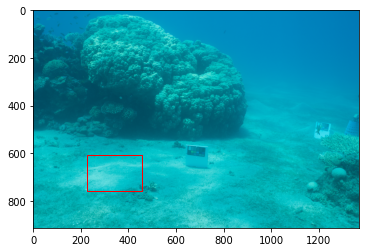

[28.564779547553094, 198.53771352723916, 203.82536934441367]

In [210]:
findBackground(imageArr, nbSplit = 6, debug=True)

In [258]:
rValues = imageArr[...,0].flatten()
gValues = imageArr[...,1].flatten()
bValues = imageArr[...,2].flatten()
index = np.random.choice(len(rValues), 200, replace=False)
rValues = rValues[index]
gValues = gValues[index]
bValues = bValues[index]

In [264]:
# R = aG + bB + c

a = 0
b = 0
c = -15
lr = 0.000001
iterations = 100
error = []
for itr in range(iterations):
    error_cost = 0
    cost_a, cost_b, cost_c = 0, 0, 0
    for i in range(len(gValues)):
        r_pred = a * gValues[i] + b * bValues[i] + c
        error_cost = error_cost + (rValues[i] - r_pred)**2
        for j in range(len(gValues)):
            partial_wrt_c = - 2 *                (rValues[j] - (a * gValues[j] + b * bValues[j] + c))
            partial_wrt_b = (- 2 * bValues[j]) * (rValues[j] - (a * gValues[j] + b * bValues[j] + c))
            partial_wrt_a = (- 2 * gValues[j]) * (rValues[j] - (a * gValues[j] + b * bValues[j] + c))
            cost_c = cost_c + partial_wrt_c
            cost_b = cost_b + partial_wrt_b
            cost_a = cost_a + partial_wrt_a
        c = c - lr * cost_c / len(gValues)
        b = b - lr * cost_b / len(gValues)
        a = a - lr * cost_a / len(gValues)
    print(itr,a,b,c)
    error.append(error_cost)
        

0 0.42997894922558744 -0.15634356361695748 -15.003178163539117
1 0.09886337048610606 -0.08816533555362945 -15.00376733612139
2 0.3618700857218229 -0.09579397882297606 -15.005687960870613
3 0.14580664761532122 -0.12965236234405056 -15.007133203136624
4 0.3294698282447044 -0.06734664547984098 -15.00845901485049
5 0.16819077203272537 -0.14906198772287138 -15.010304568828234
6 0.31396075264371875 -0.054082354015590126 -15.011349027149038
7 0.17895738519232857 -0.1580303518271689 -15.01337934166603
8 0.30644227253304984 -0.047998381762293076 -15.014290704585923
9 0.18422784761381678 -0.162061302770379 -15.016403845386199
10 0.30270443307768063 -0.04530947486053798 -15.017252231129538
11 0.18689754941940556 -0.1637581348402672 -15.019400004277633
12 0.3007559327156255 -0.044225228220955426 -15.0202185712832
13 0.1883360073465111 -0.16435218999228893 -15.022378201732595
14 0.2996548855968966 -0.043898793587318886 -15.023182626648708
15 0.18919100501963346 -0.1644258813067388 -15.0253433622988

KeyboardInterrupt: 

In [262]:
d = 3
print("true = " + str(rValues[d]))
print("predict = " + str(c + b * bValues[d] + a * gValues[d]))

true = 0
predict = -11.461381103325344
